In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.keras.utils import set_random_seed
#set_random_seed(1)
plt.rcParams["figure.figsize"] = (12,7)
sns.set_style("darkgrid")

The space embeddings dataframe, that was created in [Descriptive Statistics](./DescriptiveStatistics.ipynb) and enriched through [NLP Classification](./NLPClassification.ipynb), is loaded and split into ***X*** and ***y*** matrices used as inputs for our neural network. Normally, one would use the features to predict a target in a machine learning, but it will be done oppositely when trying to learn embeddings for a target or in our case a grid cell. 

Therefore, ***X*** simply contains a one-hot encoding of all the grid cells, which makes it a 480x480 diagonal matrix with ones. The ***y*** matrix contains the features from the space embeddings dataframe and is shown below.

In [2]:
# Load space embeddings data and prepare X and y matrices
df = pd.read_csv("data/space_embedding_data_NLP.csv", index_col=[0])
y = df[[i for i in df.columns if "_rating" not in i]].drop(["Grid"], axis=1)
X = pd.get_dummies(df.Grid).values

print("Targets (y) shape:", y.shape)
print("Input (X) shape:", X.shape)
y.head()

Targets (y) shape: (480, 21)
Input (X) shape: (480, 480)


,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,Health,...,Outdoors,Restaurant,Retail,Service,Wholesale,ReviewCount,Rating,PositiveReviews,NegativeReviews,ReviewLength
0,8,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,0.0,1.0,0.0,125,3.968571,0.696000,0.304000,0.536595
1,10,0,6,1,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,2.0,1.0,31,4.592593,0.851852,0.148148,0.802238
2,3,0,2,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,8,4.200000,0.857143,0.142857,0.999095
3,74,3,32,17,12.0,6.0,6.0,0.0,1.0,4.0,...,0.0,17.0,4.0,7.0,1.0,853,3.694524,0.732975,0.267025,0.895548
4,163,8,78,25,21.0,19.0,20.0,1.0,1.0,10.0,...,0.0,37.0,21.0,9.0,5.0,1330,3.719004,0.801535,0.198465,0.843739


It is chosen to scale the targets in order for them to be weighted as equal as possible in the loss function.

In [3]:
# Standard scaling of targets/features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y_tf = sc.fit_transform(y)

# Space Embeddings model

Now that the data for the space embeddings model has been prepared, it is time to get a better understanding of the space embeddings model. The model is a shallow neural network illustrated by a simplified drawing below:

![NN architecture](img/NN_Architecture.png)

It is seen that the model takes an input of shape (, 480), which is equal to the number of grid cells in our dataset, and feeds it to an embedding layer, which outputs embeddings of shape (, 480, *n*). The *n* refers to the length of the embedding vector, which will be found through hyperparameter tuning, but it is essential that $n<m$ where *m* is the number of features per grid cell, since we are trying to map high-dimensional data to a lower dimension. The embeddings are then flattened and fed into *m* output layers, which will output a single prediction for each feature. Thus, the neural network has *m* losses where the hyperparameter tuning will optimize the aggregation of these *m* losses.

The illustration above considers a regression task with continuous parameters and one output per feature, which will be one of two approaches conducted in this notebook:
1. A neural network with continuous targets and regression metrics
2. A neural network with uniform categorical targets and classification metrics

The first approach requires no data processing and is relatively easy to implement given the nature of the data and the architecture of such a neural network. The idea for the second approach came from a discussion with our mentor, who has had success with using categorical data where the classes are uniformly distributed. This approach will require the final output layers to be categorical where ambiguity can arise regarding the architecture.

Due to the many similarities between the two approaches, the first approach will be described more thoroughly where only differences will be highlighted in the second approach.

## Continuous features

The architecture for the two neural networks will be close to identical with the exception of the output layer(s). Naturally, the output activation and the loss function should be appropriate for a regression task, which is why a linear activation is used with a mean squared error loss. The following uses `keras-tuner` to tune the length of the embedding vector and the learning rate.

In [5]:
from keras.models import Model
from keras.layers import Dense, Embedding, Flatten
from keras import Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
# https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder_continuous(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=5, max_value=15, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer(s) - create dict of losses to save losses and list of output layers
    dict_losses = {}
    output_acts = []
    for idx in range(len(y.columns)):
        output_act = Dense(1, activation="linear", use_bias=True, name="output_layer_cont" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cont' + str(idx)] = 'mean_squared_error'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model


In [6]:
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_continuous,
                    objective=objective,
                    max_epochs=20,
                    directory="hyperparameter_tuning",
                    project_name="continuous_trials",
                    overwrite=False
)

tuner.search(X, y_tf)
best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 21s]
loss: 19.917299270629883

Best loss So Far: 11.672591209411621
Total elapsed time: 00h 05m 13s
INFO:tensorflow:Oracle triggered exit


The best model obtained in the tuning process is saved and trained for more epochs to better fit the targets.

In [7]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, y_tf, epochs=100, verbose=0)
train_loss_per_epoch = history.history['loss']

To get the model at the epoch where it was best, the epoch of the lowest loss is found and the model is retrained.

In [8]:
# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1
print("Best epoch:", best_epoch)

# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, y_tf, epochs=best_epoch, verbose=0)

# Save model
hypermodel.save("models/continuous_model")

Best epoch: 24
INFO:tensorflow:Assets written to: models/continuous_model\assets


When fitting the space embeddings, we are interested in overfitting the current problem as much as possible. Therefore, we are simply interested in getting as low a loss as possible without having to worry about performance on validation or test sets.

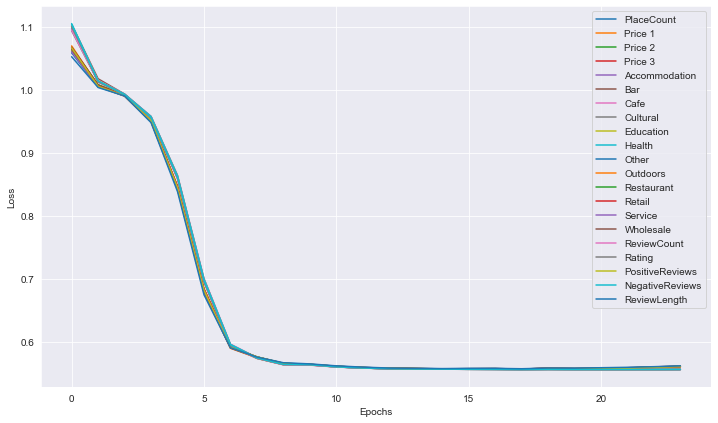

In [9]:
for idx, (key, value) in enumerate(hypermodel.history.history.items()):
    if key != "loss":
        plt.plot(hypermodel.history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

In [10]:
import pickle
weights = hypermodel.layers[1].get_weights()[0].tolist()
grids = df.Grid.values
ws = {grids[i]: weights[i] for i in range(len(df))}
with open("embeddings/continuous_embeddings.pkl", "wb") as f:
    pickle.dump(ws, f)

## Discrete/categorical features

In [11]:
# Defining a function for uniform discretizing of the features
# Can only handle features with less than 20% zero values. 
# Minimum number of bins are set to 3 and the maximum number of bins are 10

def uniform_Discretization(array): 
    # max number of bins is 10
    min_bins = 3
    max_bins = 10

    #if input contains zeros, adjust max number of bins
    try:
        calc_bins = np.int32(np.floor(1/(len(np.where(array==0)[0])/len(array))))
        if np.any(array==0) and calc_bins < max_bins and calc_bins-min_bins>0:
            max_bins = calc_bins
    except ZeroDivisionError:
        None
    # find optimal number of bins with least variation in binsize
    minspan = []
    for i in range(min_bins, max_bins+1, 1):
        try:
            Value_count = pd.qcut(array,i).value_counts()
            minspan.append(max(Value_count)-min(Value_count))
        except ValueError:
            minspan.append(1000)
            continue

    bins = np.argmin(minspan)+min_bins
    intervals = np.unique(pd.qcut(array,bins))

    # print number of bins and bin intervals
    print(array.name,'- Bins: ', bins,'--',' '.join(str(x) for x in intervals))

    # uniform discretized bin 
    uniform_vals = pd.qcut(array,bins, labels=False)
    
    return uniform_vals


In [12]:
import pandas as pd
# Transforming the dataset to uniform discretized values, for features with less than 20% zeros
y_discrete = pd.DataFrame()
for col in y.columns:
    if len(np.where(y[col]==0)[0])/len(y[col])<0.2:
        y_discrete[col] = uniform_Discretization(y[col])
        y_discrete[col] = y_discrete[col].astype("category", copy=False)

PlaceCount - Bins:  3 -- (0.999, 14.667] (14.667, 46.0] (46.0, 669.0]
Price 2 - Bins:  6 -- (-0.001, 3.0] (3.0, 7.0] (7.0, 12.0] (12.0, 22.0] (22.0, 55.167] (55.167, 379.0]
Price 3 - Bins:  3 -- (-0.001, 1.0] (1.0, 6.333] (6.333, 112.0]
Bar - Bins:  4 -- (-0.001, 1.0] (1.0, 3.0] (3.0, 9.0] (9.0, 133.0]
Other - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 91.0]
Restaurant - Bins:  5 -- (-0.001, 1.0] (1.0, 4.0] (4.0, 9.4] (9.4, 25.0] (25.0, 263.0]
ReviewCount - Bins:  5 -- (3.999, 40.8] (40.8, 99.2] (99.2, 225.4] (225.4, 638.2] (638.2, 8699.0]
Rating - Bins:  3 -- (1.5550000000000002, 3.941] (3.941, 4.13] (4.13, 5.0]
PositiveReviews - Bins:  4 -- (0.311, 0.792] (0.792, 0.833] (0.833, 0.864] (0.864, 1.0]
NegativeReviews - Bins:  4 -- (-0.001, 0.136] (0.136, 0.167] (0.167, 0.208] (0.208, 0.688]
ReviewLength - Bins:  3 -- (0.0665, 0.899] (0.899, 1.099] (1.099, 2.218]


In [13]:
data = []
for c in y_discrete:
    arr = np.asarray(pd.get_dummies(y_discrete[c]).values)
    data.append(arr)

In [14]:
def model_builder_discrete(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=3, max_value=8, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer
    dict_losses = {}
    output_acts = []
    for idx in range(len(y_discrete.columns)):
        n_output = y_discrete.iloc[:, idx].nunique()
        output_act = Dense(n_output, activation="softmax", use_bias=True, name="output_layer_cat" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cat' + str(idx)] = 'categorical_crossentropy'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model

In [15]:
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_discrete,
                    objective=objective,
                    max_epochs=20,
                    directory="hyperparameter_tuning",
                    project_name="discrete_trials",
                    overwrite=False
)

#tuner.search(X, output_space, callbacks=[stop_early])
tuner.search(X, data)

best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 09s]
loss: 0.005318881012499332

Best loss So Far: 0.003040631767362356
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit


In [22]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, data, epochs=300, verbose=0)

train_loss_per_epoch = history.history['loss']

# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1
print("Best epoch:", best_epoch)

Best epoch: 300


In [23]:
# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, data, epochs=best_epoch, verbose=0)

# Save model
hypermodel.save("models/discrete_model")

INFO:tensorflow:Assets written to: models/discrete_model\assets


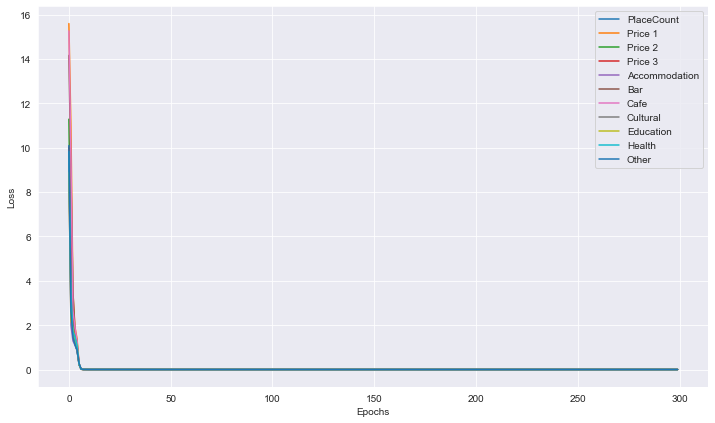

In [24]:
for idx, (key, value) in enumerate(hypermodel.history.history.items()):
    if key != "loss":
        plt.plot(hypermodel.history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

In [28]:
import pickle
weights = hypermodel.layers[1].get_weights()[0].tolist()
grids = df.Grid.values
ws = {grids[i]: weights[i] for i in range(len(df))}
with open("embeddings/discrete_embeddings.pkl", "wb") as f:
    pickle.dump(ws, f)

## Model comparison (Continuous vs Discrete/Categorical)

- Describe challenges regarding evaluating embeddings performance

We choose discrete model:
- Describe differences in loss curves
    - Discrete model keeps learning
- TSNE plot with points scattered fine
- We choose discrete based on mentor's suggestions and that it keeps learning

In [31]:
from tensorflow import keras
cont_model = keras.models.load_model("models/continuous_model")
disc_model = keras.models.load_model("models/discrete_model")

Create TSNE plot and see if there are random clusters with each city

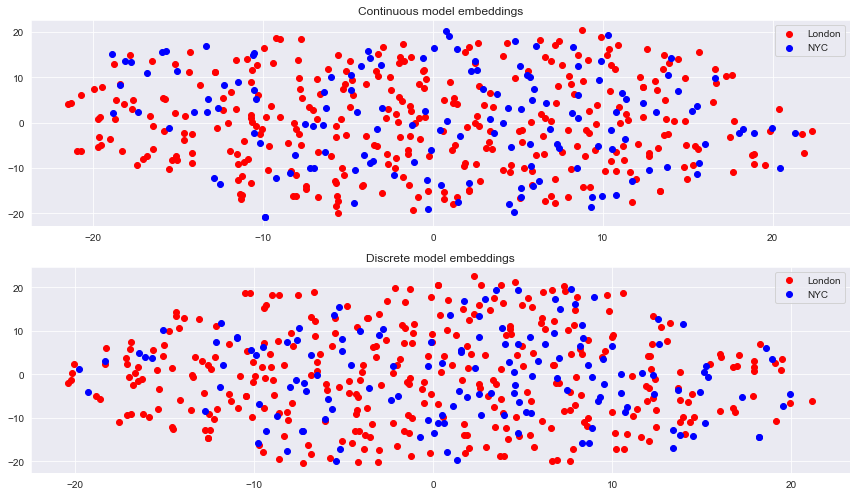

In [32]:
from sklearn.manifold import TSNE
# Apply TSNE to lower dimension of embeddings
cont_embeddings = cont_model.layers[1].get_weights()[0]
disc_embeddings = disc_model.layers[1].get_weights()[0]
X_cont = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(cont_embeddings)
X_disc = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(cont_embeddings)

# Find index of London and NYC grids for scatter plot
fig, ax = plt.subplots(2,1)
london_idx = np.where((df.Grid.str.startswith("L")*1).values==1)
nyc_idx = np.where((df.Grid.str.startswith("N")*1).values==1)

# Create scatter plot for continuous model
ax[0].scatter(X_cont[london_idx, 0], X_cont[london_idx, 1], color="red", label="London")
ax[0].scatter(X_cont[nyc_idx, 0], X_cont[nyc_idx, 1], color="blue", label="NYC")
ax[0].legend()
ax[0].set_title("Continuous model embeddings")

# Create scatter plot for discrete model
ax[1].scatter(X_disc[london_idx, 0], X_disc[london_idx, 1], color="red", label="London")
ax[1].scatter(X_disc[nyc_idx, 0], X_disc[nyc_idx, 1], color="blue", label="NYC")
ax[1].legend()
ax[1].set_title("Discrete model embeddings")
fig.tight_layout()